In [1]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from scholarly import scholarly, ProxyGenerator

In [42]:
def get_pubmed_count(query, year):
    # url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=%22{term}%22&retmax=100000&mindate={year}&maxdate={year}&usehistory=y"
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pmc&term={query}&mindate={year}&maxdate={year}&retmax=100000&usehistory=y"
    
    response = requests.get(url)
    if "<Count>" in response.text:
        count = int(response.text.split("<Count>")[1].split("</Count>")[0])
    else:
        print(f"No count found for year {year}. Response: {response.text}")
        count = 0
    return count

def get_pubmed_titles_and_authors(query, year):
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pmc&term={query}&mindate={year}&maxdate={year}&retmax=100000&usehistory=y"
    
    response = requests.get(url)
    if response.status_code == 200 and "<WebEnv>" in response.text:
        webenv = response.text.split("<WebEnv>")[1].split("</WebEnv>")[0]
        query_key = response.text.split("<QueryKey>")[1].split("</QueryKey>")[0]
        fetch_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pmc&query_key={query_key}&WebEnv={webenv}&retmax=100000"
        
        fetch_response = requests.get(fetch_url)
        if fetch_response.status_code == 200:
            titles_and_authors = []
            root = ET.fromstring(fetch_response.text)
            for docsum in root.findall(".//DocSum"):
                title = docsum.find(".//Item[@Name='Title']").text
                authors = [author.text for author in docsum.findall(".//Item[@Name='Author']")]
                titles_and_authors.append((title, authors))
            return titles_and_authors
    return []

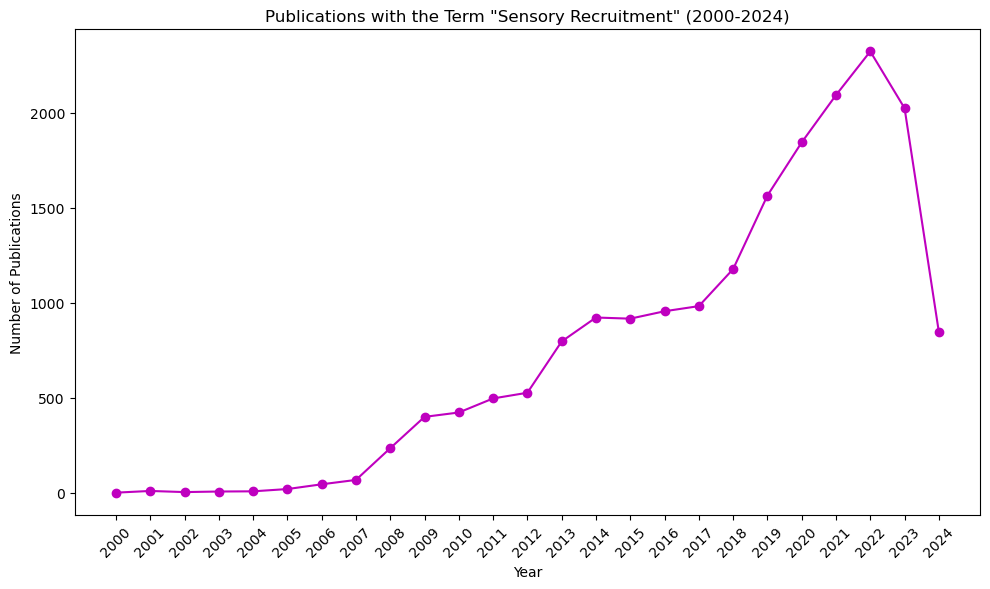

In [43]:
# years = list(range(2000, 2025))
years = list(range(2000, 2025))
# counts = [get_pubmed_count("sensory recruitment", year) for year in years]

counts = []
all_titles_and_authors = []
query = f"%22sensory%22+AND+%22recruitment%22+AND+%22working%22+AND+%22memory%22" #+AND+%22working memory%22"
for year in years:

    counts.append(get_pubmed_count(query, year))
    titles_and_authors = get_pubmed_titles_and_authors(query, year)
    all_titles_and_authors.append((year, titles_and_authors))
    time.sleep(1)

plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', color='m')
plt.title('Publications with the Term "Sensory Recruitment" (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
# plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

In [44]:
for year, titles_and_authors in all_titles_and_authors:
    print(f"\nYear: {year}")
    for title, authors in titles_and_authors:
        print(f" - Title: {title}")
        print(f"   Authors: {', '.join(authors)}")


Year: 2000

Year: 2001
 - Title: Neurotrophins in bronchial asthma
   Authors: Renz H
 - Title: Speech-like cerebral activity in profoundly deaf people processing signed languages: Implications for the neural basis of human language
   Authors: Petitto LA, Zatorre RJ, Gauna K, Nikelski EJ, Dostie D, Evans AC
 - Title: The genetic mediation of individual differences in sensitivity to pain and its inhibition
   Authors: Mogil JS
 - Title: The roles of prefrontal brain regions in components of working memory: Effects of memory load and individual differences
   Authors: Rypma B, D’Esposito M
 - Title: Inhibition in verbal working memory revealed by brain activation
   Authors: Jonides J, Smith EE, Marshuetz C, Koeppe RA, Reuter-Lorenz PA
 - Title: Functional anatomy of musical processing in listeners with absolute pitch and relative pitch
   Authors: Zatorre RJ, Perry DW, Beckett CA, Westbury CF, Evans AC
 - Title: The acquisition of skilled motor performance: Fast and slow experience-dr

In [5]:
def get_google_scholar_data(term1, term2, year):
    search_query = f'"{term1}" AND "{term2}" {year}'
    search_results = scholarly.search_pubs(search_query)
    print(search_results)
    titles = []
    count = 0
    for result in search_results:
        if str(year) in result['bib']['pub_year']:
            titles.append(result['bib']['title'])
            count += 1
    return count, titles

# Setting up ProxyGenerator for Google Scholar
# pg = ProxyGenerator()
# pg.FreeProxies()
# scholarly.use_proxy(pg)

In [6]:
term1 = "sensory recruitment"
term2 = "working memory"

years = list(range(2000, 2025))
counts = []
all_titles = []

for year in years:
    print(year)
    pg = ProxyGenerator()
    pg.FreeProxies()
    scholarly.use_proxy(pg)
    count, titles = get_google_scholar_data(term1, term2, year)
    counts.append(count)
    all_titles.extend(titles)
    time.sleep(1)

2000
2001


MaxTriesExceededException: Cannot Fetch from Google Scholar.

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', color='b')
plt.title('Publications with the Terms "Sensory Recruitment" and "Working Memory" (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

for title in all_titles:
    print(title)

In [4]:
def search_articles_by_keywords(keywords, max_retries=5):
    pg = ProxyGenerator()
    pg.FreeProxies()
    scholarly.use_proxy(pg)
    search_query = scholarly.search_pubs(keywords)
    articles = []
    years = []
    authors = []
    
    for _ in range(max_retries):
        try:
            search_query = scholarly.search_pubs(keywords)
            for article in search_query:
                if 'bib' in article:
                    articles.append(article['bib']['title'])
                    years.append(article['bib']['pub_year'])
                    authors.append(article['bib']['author'])
            break  
        except Exception as e:
            print(f"An error occurred: {e}. Retrying...")
            time.sleep(10)  

    if not articles:
        raise Exception("Failed to fetch articles after multiple retries.")

    return articles, years, authors

def main():
    # keyword = '"sensory recruitment" AND "working memory"'
    keyword = '("TMS" OR "Transcranial Magnetic Stimulation" OR "Brain stimulation") AND "working memory" AND ("sensory recruitment" OR "early visual" OR "early sensory" OR "visual cortex")'

    articles, years, authors = search_articles_by_keywords(keyword)
    articles_df = pd.DataFrame({'title': articles, 'year': years, 'authors': authors})
    return articles_df
    # print(articles_df)

In [5]:
if __name__ == "__main__":
    articles_df = main()

MaxTriesExceededException: Cannot Fetch from Google Scholar.

In [7]:
tdf = articles_df.groupby('year').size().reset_index(name='counts')

In [8]:
tdf

year  counts
0   2000       1
1   2002       2
2   2005       1
3   2007       1
4   2008       1
5   2009       4
6   2010       3
7   2011       9
8   2012      11
9   2013      13
10  2014      15
11  2015      24
12  2016      27
13  2017      35
14  2018      46
15  2019      49
16  2020      55
17  2021      56
18  2022      65
19  2023      78
20  2024      27
21    NA      26

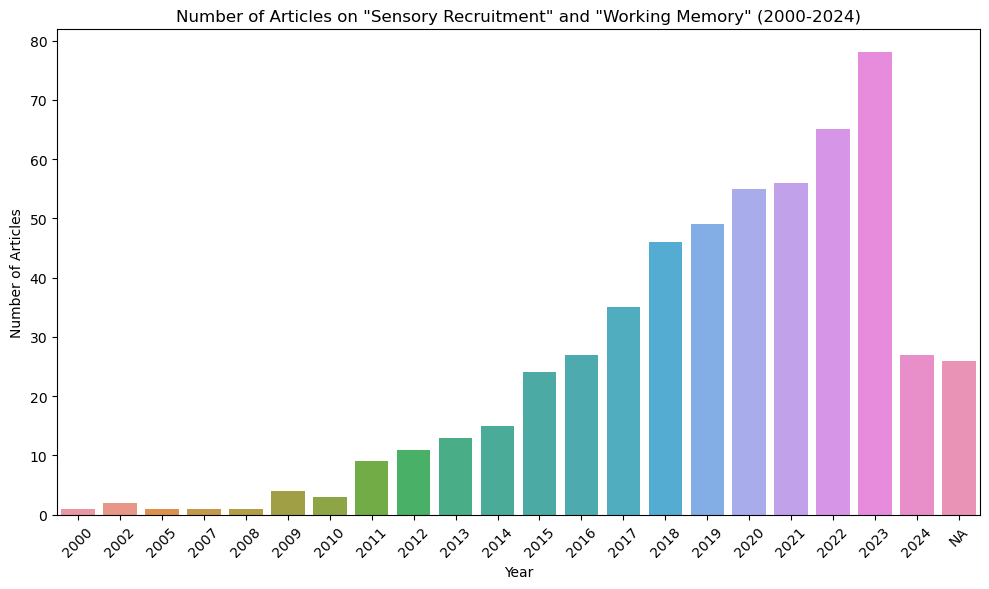

In [10]:
# Create a figure with number of articles per year between 2000 and 2024, sorted by year
plt.figure(figsize=(10, 6))
sns.barplot(x='year', y='counts', data=tdf)
plt.title('Number of Articles on "Sensory Recruitment" and "Working Memory" (2000-2024)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# Make a text file with name of article and authors for each year in same text file
with open('articles_tms.txt', 'w') as f:
    for year in sorted(articles_df['year'].unique()):
        f.write(f"Year: {year}\n")
        articles = articles_df[articles_df['year'] == year]
        for _, row in articles.iterrows():
            f.write(f" - Title: {row['title']}\n")
            f.write(f"   Authors: {row['authors']}\n")
        f.write("\n")